# Assignment 3
## Anton Marin

Some imports

In [1]:
import numpy as np
import datetime
from matplotlib import pyplot as plt
%matplotlib inline

Defining RMSE function

In [26]:
def rmse(a,b):
    assert a.shape == b.shape
    return (np.sum((a-b)**2)/a.shape[0])**0.5

Loading data

In [3]:
with open('data/omni2_3390.txt', 'r') as f:
    lines = f.readlines()

Parsing values from txt file

In [8]:
shape = len(lines)
dates = []
Bz = []
V = []
P = []
Dst = []
for i in range(shape):
    line = lines[i].split()
    date = datetime.datetime(year=int(line[0]), month=1, day=1) + datetime.timedelta(days=int(line[1])-1, hours=int(line[2]))
    dates.append(date)
    Bz.append(float(line[3]))
    V.append(float(line[4]))
    P.append(float(line[5]))
    Dst.append(float(line[6]))
Dst = np.array(Dst)
Bz = np.array(Bz)
V = np.array(V)
P = np.array(P)

Plotting Dst

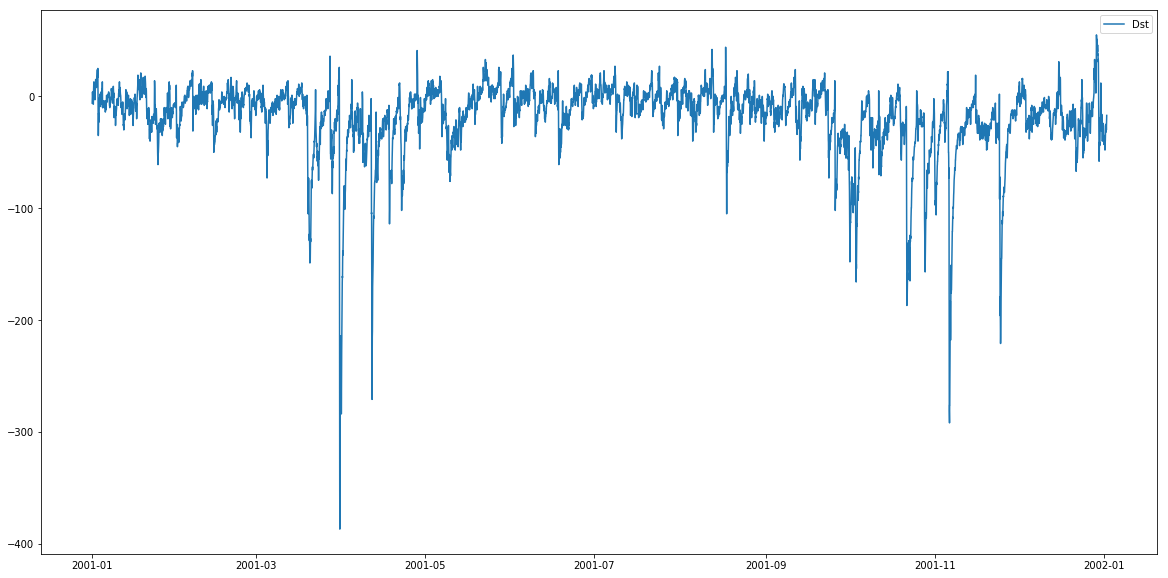

In [9]:
plt.figure(figsize=(20,10))
plt.plot(dates, Dst, label='Dst')
plt.legend()

VBs calculation functions

In [61]:
def _VBs(Bz, V):
    assert Bz.shape == V.shape
    res = np.zeros(Bz.shape)
    for i in range(Bz.shape[0]):
        if Bz[i]<0:
            res[i] = abs(Bz[i]*V[i])/10**3
    return res

In [62]:
VBs = _VBs(Bz, V)

Defining Model class, regardless of specific implementation

In [70]:
class Model:
    VBs = None
    P = None
    b = None
    c = None
    
    @classmethod
    def initialize(cls, VBs, P):
        cls.Vbs = VBs
        cls.P = P
        
    @classmethod
    def tau(cls, t):
        pass
    
    @classmethod
    def Q(cls, t):
        pass
    
    @classmethod
    def predict_dst(cls, Dst_corrected):
        Dst_predicted = np.zeros(Dst_corrected.shape[0])
        for i in range(Dst_corrected.shape[0]):
            Dst_predicted[i] = Dst_corrected[i] + (cls.Q(i) - Dst_corrected[i]/cls.tau(i))
        return Dst_predicted
    
    @classmethod
    def correct_dst(cls, Dst):
        return Dst - cls.b*(cls.P**0.5) + cls.c

Defining models implementation

In [71]:
class AK1(Model):
    b=8.74
    c=11.5
    @classmethod
    def tau(cls, t):
        return 17.0
    
    @classmethod
    def Q(cls, t):
        return -2.47 * cls.Vbs[t]
    
class UCB(Model):
    b=15.8
    c=20
    @classmethod
    def tau(cls, t):
        if cls.Vbs[t]>4:
            return 3
        else:
            return 7.7
    
    @classmethod
    def Q(cls, t):
        if cls.Vbs[t]>0.5:
            return -4.32*(cls.Vbs[t]-0.5)*(cls.P[t])**(1/3)
        else:
            return 0
    
class AK2(Model):
    b=7.26
    c=11
    @classmethod
    def tau(cls, t):
        return 2.4*np.exp(9.74/(4.69 + cls.Vbs[t]))
    
    @classmethod
    def Q(cls, t):
        return -4.4*(cls.Vbs[t]-0.5)

Initialization of models with given Vbs, P to store then in class variables

In [72]:
AK1.initialize(VBs, P)
UCB.initialize(VBs, P)
AK2.initialize(VBs, P)

Correcting and predictiting Dst

In [78]:
dst_corrected_ak1 = AK1.correct_dst(Dst)
dst_pred_ak1 = AK1.predict_dst(dst_corrected_ak1)

dst_corrected_ucb = UCB.correct_dst(Dst)
dst_pred_ucb = UCB.predict_dst(dst_corrected_ucb)

dst_corrected_ak2 = AK2.correct_dst(Dst)
dst_pred_ak2 = AK2.predict_dst(dst_corrected_ak2)

Comparing the results

In [97]:
# Model AK1
rmse(dst_pred_ak1[:-1], Dst[1:])

28.262037406948004

In [98]:
# Model UBC
rmse(dst_pred_ucb[:-1], Dst[1:])

202.43882894933995

In [92]:
# Model AK2
rmse(dst_pred_ak2[:-1], Dst[1:])

43.090527104710453

# Conclusion

In total, model 1's performance was the best, ot differs from results of the paper